In [1]:
import pandas as pd
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
frame_test = pd.read_csv("hq_markup_train.csv")
frame = pd.read_csv("markup_train.csv")

def get_sample(index, frame):
    uuid = frame.iloc[index, 0]
    with open(f'data/{uuid}', 'r') as f:
        content = f.read()
    rows = [line.split('\t') for line in content.strip().split('\n')]
    data = pd.DataFrame(rows, columns=['time', 'delta_p', 'p_'], dtype=float)
    return data


def find_empty_indexes_2(data):
    """
    Поиск id файлов из строк датафрейма для их исключения на этапе удаления данных из датафрейма
    """
    B=[]
    for i in range(data.shape[0]):
        try:
            df=get_sample(i,data)
        except ValueError:
            B.append(data.iloc[i,0])
    return B


class SiamDataset(Dataset):
    def __init__(self, siam_dataset_describe:pd.DataFrame):
        super().__init__()
        self.siam_dataset_describe = siam_dataset_describe

    def __len__(self):
        return self.siam_dataset_describe.shape[0]

    def __getitem__(self, idx):
        x = get_sample(idx, self.siam_dataset_describe) #.to_numpy(dtype=np.float64)
        # t = x["time"].to_numpy(dtype=np.float64)
        x = x[["delta_p", "p_"]].to_numpy(dtype=np.float64)
        


        # 7) Возвращаем (X, Y)                                                  # Давление(атм) ([:, 1]) Давление(атм) ([:,1]) Давление(атм) ([:,1]) Давление(атм) ([:,1]) Давление(атм) ([:,1]) В какой момент? [:, 0]   В какой момент? [:, 0]
        return x, self.siam_dataset_describe.iloc[idx][['Влияние ствола скважины_details', 'Радиальный режим_details', 'Линейный режим_details', 'Билинейный режим_details', 'Сферический режим_details', 'Граница постоянного давления_details', 'Граница непроницаемый разлом_details']].to_numpy(dtype=np.float32)

# B=find_empty_indexes_2(frame)#Поиск id с отсутствующими файлами для исключения
# frame=frame[~frame['file_name'].isin(B)]#Фильтрация данных
# frame = frame[~frame["file_name"].isin(frame_test["file_name"])]

In [2]:
import numpy as np
# TESTED
def extract_window_with_padding(data, col_index, y, N):
    # Найти индекс строки, где значение в 3-м столбце ближе всего к y
    i = np.argmin(np.abs(data[:, col_index] - y))
    
    # Общее количество строк в массиве
    M = data.shape[0]
    
    # Вычислить количество строк паддинга слева и справа
    padding_left = N - i if i < N else 0
    padding_right = N - (M - i - 1) if M - i - 1 < N else 0
    
    # Определить границы окна
    start = max(0, i - N)
    end = min(M, i + N + 1)
    
    # Собрать окно с паддингом
    window = np.vstack((np.zeros((padding_left, 3)), data[start:end, :], np.zeros((padding_right, 3))))
    # np.pad(arr, ((N, N), (0, 0)), mode='constant')
    
    return window

data = np.array([[1,2,3], [2,3,4], [5,6,7]])
y = 3
N = 3

extract_window_with_padding(data, 1, y, N)

array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 2., 3.],
       [2., 3., 4.],
       [5., 6., 7.],
       [0., 0., 0.],
       [0., 0., 0.]])

Влияние ствола скважины_details 0
[[ 5.90833333 15.56267859  1.56227492]
 [ 6.05       15.58989105  1.59465351]
 [ 6.19166667 15.61734083  1.63589845]
 [ 6.34166667 15.64613541  1.6689356 ]
 [ 6.49166667 15.67485088  1.69164055]
 [ 6.64166667 15.70348724  1.72947881]
 [ 6.8        15.73315199  1.75868551]
 [ 6.95833333 15.7624212   1.7901511 ]
 [ 7.125      15.79343075  1.82553246]
 [ 7.29166667 15.82357013  1.86066561]
 [ 7.46666667 15.85465878  1.89479967]
 [ 7.64166667 15.88551012  1.92746336]
 [ 7.825      15.91754804  1.96548571]
 [ 8.00833333 15.9487158   1.99879181]
 [ 8.2        15.98114925  2.0345966 ]
 [ 8.39166667 16.01342449  2.06534921]
 [ 8.59166667 16.04593705  2.09876839]
 [ 8.79166667 16.07852872  2.13008109]
 [ 9.         16.11199055  2.16436799]
 [ 9.20833333 16.14505685  2.19667065]
 [ 9.425      16.17907242  2.23059687]
 [ 9.65       16.21379995  2.26523552]
 [ 9.875      16.24844837  2.29892551]
 [10.10833333 16.28372964  2.3339655 ]
 [10.34166667 16.31829896  2.3

KeyboardInterrupt: 

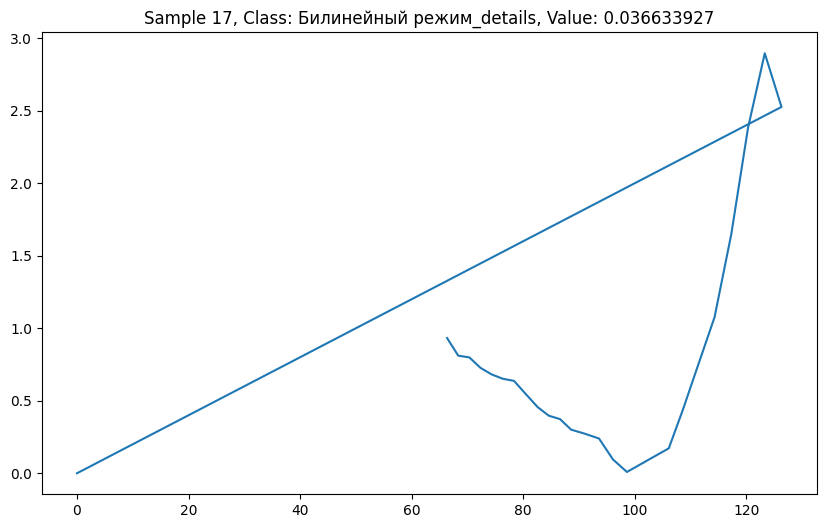

In [32]:
import os
def process_and_save_windows(siam_dataset_describe, base_output_dir, window_size=50):
    """
    Обрабатывает данные из DataFrame, извлекает окна и сохраняет их по классам
    
    Args:
        siam_dataset_describe: DataFrame с метками классов
        base_output_dir: Базовый каталог для сохранения результатов
        window_size: Размер окна для функции extract_window_with_padding
    """
    # Создание базового каталога, если он не существует
    os.makedirs(base_output_dir, exist_ok=True)
    
    # Список классов
    class_columns = [
        'Влияние ствола скважины_details',
        'Радиальный режим_details',
        'Линейный режим_details',
        'Билинейный режим_details',
        'Сферический режим_details',
        'Граница постоянного давления_details',
        'Граница непроницаемый разлом_details'
    ]
    
    # Для каждой строки в DataFrame
    for idx in range(siam_dataset_describe.shape[0]):
        # Получаем данные образца
        sample_data = get_sample(idx, siam_dataset_describe)
        # Преобразуем в numpy массив
        data_with_index = sample_data[["time", "delta_p", "p_"]].to_numpy(dtype=np.float64)
        # print(sample_data["time"])
        # Добавим колонку индексов для использования в extract_window_with_padding
        # Предположим, что нам нужен массив с 3 колонками для extract_window_with_padding
        # data_with_index = np.column_stack(x_data))
        
        # Обработка первых 5 столбцов (признаки во втором столбце)
        for i, class_name in enumerate(class_columns[:5]):
            # Проверяем, есть ли метка для данного класса (не равна ли NaN или 0)
            class_value = siam_dataset_describe.iloc[idx][class_name]
            if pd.notna(class_value) and class_value != 0:
                # Создаем папку для класса, если её нет
                class_dir = os.path.join(base_output_dir, class_name)
                os.makedirs(class_dir, exist_ok=True)
                
                # Извлекаем окно для признака во втором столбце (индекс 1 в data_with_index)
                window = extract_window_with_padding(data_with_index, 2,  class_value, window_size)
                print(class_name, idx)
                print(window)
                # Создаем уникальное имя файла
                file_name = f"{idx}_{class_name}_{class_value}.npy"
                file_path = os.path.join(class_dir, file_name)
                
                # Сохраняем окно
                np.save(file_path, window)
                class_dir = os.path.join(base_output_dir, class_name, "graf")
                # Опционально: можно также сохранить визуализацию для проверки
                plt.figure(figsize=(10, 6))
                plt.plot(window[:, 0], window[:, 2])  # Построение delta_p vs p_
                plt.title(f"Sample {idx}, Class: {class_name}, Value: {class_value}")
                plt.savefig(file_path.replace('.npy', '.png'))
                plt.close()
        
        # Обработка последних 2 столбцов (признаки в нулевом столбце)
        for i, class_name in enumerate(class_columns[5:], 5):
            # Проверяем, есть ли метка для данного класса
            class_value = siam_dataset_describe.iloc[idx][class_name]
            if pd.notna(class_value) and class_value != 0:
                # Создаем папку для класса, если её нет
                class_dir = os.path.join(base_output_dir, class_name)
                os.makedirs(class_dir, exist_ok=True)
                
                # Извлекаем окно для признака в нулевом столбце (индекс 0 в data_with_index)
                window = extract_window_with_padding(data_with_index, 0, class_value, window_size)
                
                # Создаем уникальное имя файла
                file_name = f"{idx}_{class_name}_{class_value}.npy"
                file_path = os.path.join(class_dir, file_name)
                
                # Сохраняем окно
                np.save(file_path, window)
                
                class_dir = os.path.join(base_output_dir, class_name, "graf")
                # Опционально: можно также сохранить визуализацию для проверки
                plt.figure(figsize=(10, 6))
                plt.plot(window[:, 0], window[:, 2])  # Построение delta_p vs p_
                plt.title(f"Sample {idx}, Class: {class_name}, Value: {class_value}")
                plt.savefig(file_path.replace('.npy', '.png'))
                plt.close()

process_and_save_windows(frame_test, "./output_windows", 15)

0.0750000000698492
0.07499999989522621
0.0750000000698492
0.07500000006984917
0.07499999972060326
0.07500000006984914
0.07500000024447223
0.07500000006984922
0.07499999989522621
0.07499999989522621
0.09166666679084298
0.0750000002444721
0.07500000006984922
0.07499999989522618
0.07499999989522621
0.07500000006984922
0.07499999989522621
0.0750000000698492
0.0750000002444722
0.07500000006984922
0.07499999989522618
0.0749999998952263
0.07500000006984922
0.07499999989522618
0.07500000006984917
0.07500000024447218
0.07499999972060323
0.07499999989522621
0.07499999989522621
0.0750000000698492
0.07499999989522621
0.0750000000698492
0.07500000024447223
0.08333333325572312
0.09166666661622003
0.1000000003259629
0.10833333316259086
0.11666666669771075
0.12499999988358473
0.1333333334187045
0.14166666660457844
0.14999999996507535
0.1499999999650754
0.14999999979045242
0.1499999999650754
0.1500000001396984
0.1499999999650754
0.1500000001396984
0.18333333323244005
0.20000000012805685
0.1833333332324

d:\Python3\Lib\site-packages\scipy\stats\_stats_py.py:10919: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
d:\Python3\Lib\site-packages\scipy\stats\_stats_py.py:10933: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
d:\Python3\Lib\site-packages\scipy\stats\_stats_py.py:10936: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


0.11666666669771078
0.11666666669771078
0.11666666669771075
0.11666666669771075
0.11666666669771075
0.11666666634846476
0.11666666669771081
0.11666666669771072
0.11666666669771081
0.11666666669771078
0.11666666669771078
0.11666666652308778
0.11666666669771071
0.11666666669771071
0.11666666669771072
0.11666666669771072
0.11666666669771081
0.11666666669771081
0.11666666652308783
0.11666666669771078
0.1166666666977107
0.1250000000582077
0.11666666669771072
0.11666666652308769
0.1166666666977107
0.1250000002328307
0.12500000005820766
0.1250000000582076
0.13333333324408148
0.14166666677920137
0.1499999999650754
0.1583333335001953
0.18333333305781713
0.18333333340706304
0.20833333348855382
0.20833333331393072
0.21666666667442763
0.22500000003492454
0.24999999994179234
0.23333333339542156
0.23333333322079858
0.2333333333954215
0.2666666664881632
0.2333333333954215
0.2416666667559184
0.24999999976716936
0.28333333338378
0.2749999996740371
0.28333333355840296
0.2916666667442769
0.30000000010477

d:\Python3\Lib\site-packages\scipy\stats\_stats_py.py:10919: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
d:\Python3\Lib\site-packages\scipy\stats\_stats_py.py:10933: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
d:\Python3\Lib\site-packages\scipy\stats\_stats_py.py:10936: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


KeyboardInterrupt: 

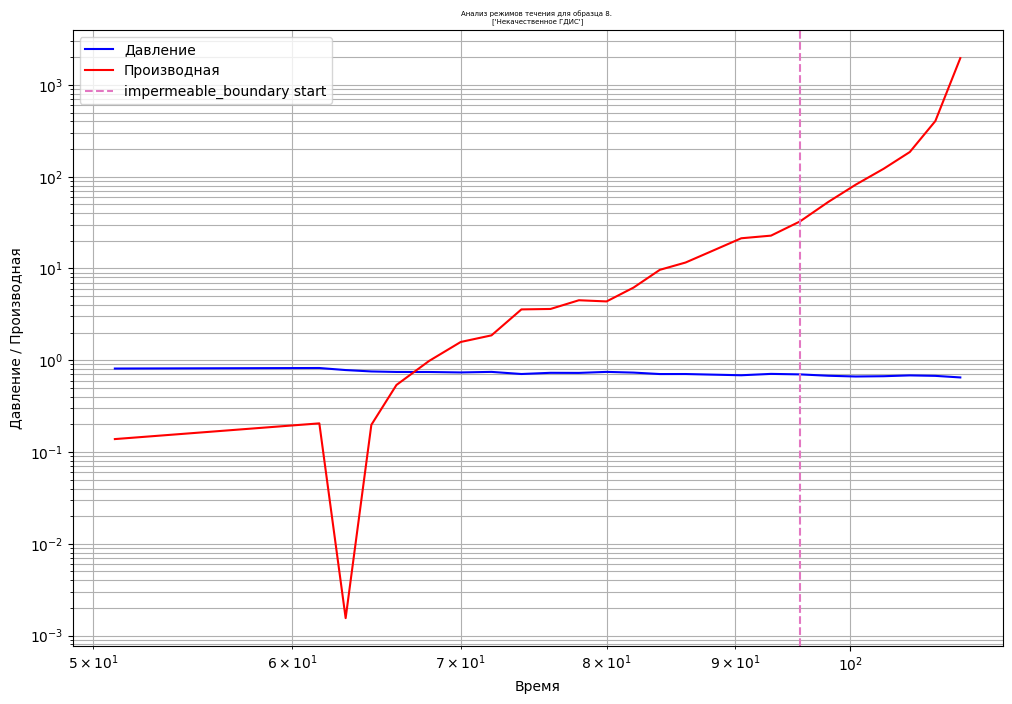

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from scipy import stats
from scipy.signal import savgol_filter

# def get_sample(idx, df):
#     # Предполагается, что эта функция загружает необходимые данные
#     # Заглушка для примера, в реальном коде нужно заменить на вашу функцию
#     # Возвращает DataFrame с колонками "delta_p" и "p_"
#     pass

# def extract_window_with_padding(data, y, N): 
#     # Найти индекс строки, где значение в 3-м столбце ближе всего к y 
#     i = np.argmin(np.abs(data[:, 2] - y)) 
     
#     # Общее количество строк в массиве 
#     M = data.shape[0] 
     
#     # Вычислить количество строк паддинга слева и справа 
#     padding_left = N - i if i < N else 0 
#     padding_right = N - (M - i - 1) if M - i - 1 < N else 0 
     
#     # Определить границы окна 
#     start = max(0, i - N) 
#     end = min(M, i + N + 1) 
     
#     # Собрать окно с паддингом 
#     window = np.vstack((np.zeros((padding_left, 3)), data[start:end, :], np.zeros((padding_right, 3)))) 
     
#     return window

def calculate_log_derivative(time, pressure):
    """
    Рассчитывает логарифмическую производную давления.
    
    Args:
        time: Массив времени
        pressure: Массив давления
    
    Returns:
        Логарифмическая производная давления
    """
    # Фильтрация данных для уменьшения шума
    pressure_filtered = savgol_filter(pressure, window_length=11, polyorder=3)
    
    # Рассчет производной
    derivative = np.zeros_like(pressure_filtered)
    for i in range(1, len(time) - 1):
        derivative[i] = (pressure_filtered[i+1] - pressure_filtered[i-1]) / (np.log10(time[i+1]) - np.log10(time[i-1]))
    
    # Для первой и последней точки используем одностороннюю разницу
    derivative[0] = (pressure_filtered[1] - pressure_filtered[0]) / (np.log10(time[1]) - np.log10(time[0]))
    derivative[-1] = (pressure_filtered[-1] - pressure_filtered[-2]) / (np.log10(time[-1]) - np.log10(time[-2]))
    
    return derivative

def detect_slope(log_x, log_y, window_size=10, min_cycle_length=0.5):
    """
    Определяет наклон (k) и смещение (b) линейного участка на логарифмическом графике.
    
    Args:
        x: Массив времени
        y: Массив значений (давление или производная)
        window_size: Размер окна для анализа (в точках)
        min_cycle_length: Минимальная длина участка в логарифмических циклах
    
    Returns:
        Список кортежей (start_idx, end_idx, slope, intercept) для каждого обнаруженного участка
    """
    # log_x = np.log10(x)
    temp_log_x = np.log10(np.arange(1, log_x.shape[0]))
    # log_y = np.log10(y)
    
    slopes = []
    detected_segments = []
    
    for i in range(0, len(log_x) - window_size):
        # Берем участок данных
        x_segment = log_x[i:i+window_size]
        y_segment = log_y[i:i+window_size]
        
        # Проверяем, что в сегменте нет NaN или бесконечностей
        if np.any(np.isnan(y_segment)) or np.any(np.isinf(y_segment)):
            continue
        
        # Линейная регрессия для определения наклона
        res = stats.linregress(x_segment, y_segment)
        # slope, intercept, r_value, p_value, std_err = stats.linregress(x_segment, y_segment)
        slope = res.slope
        intercept = res.intercept
        r_value = res.rvalue
        # Если корреляция высокая, считаем, что нашли линейный участок
        if abs(r_value) > 0.1:
            slopes.append((i, i+window_size, slope, intercept, r_value))
    
    # Объединяем перекрывающиеся сегменты с похожими наклонами
    if slopes:
        current_segment = slopes[0]
        
        for i in range(1, len(slopes)):
            # slopes[i], current_segment
            # Если наклон в пределах допустимой погрешности и сегменты перекрываются
            if (abs(slopes[i][2] - current_segment[2]) < 0.1 and 
                slopes[i][0] <= current_segment[1]):
                # Расширяем текущий сегмент
                current_segment = (current_segment[0], slopes[i][1], 
                                  (current_segment[2] + slopes[i][2]) / 2,
                                  (current_segment[3] + slopes[i][3]) / 2,
                                  (current_segment[4] + slopes[i][4]) / 2)
            else:
                # Проверяем минимальную длину в логарифмических циклах
                segment_length = log_x[current_segment[1]] - log_x[current_segment[0]]
                print(segment_length)
                if segment_length >= min_cycle_length:
                    detected_segments.append(current_segment)
                current_segment = slopes[i]
        
        # Добавляем последний сегмент, если он достаточно длинный
        segment_length = log_x[current_segment[1]-1] - log_x[current_segment[0]]
        if segment_length >= min_cycle_length:
            detected_segments.append(current_segment)

        print(len(detected_segments))
    
    return slopes #detected_segments


def analyze_flow_regimes(time, pressure, derivative):
    """
    Анализирует данные давления и производной для выявления режимов течения.
    
    Args:
        time: Массив времени
        pressure: Массив давления
        derivative: Массив логарифмической производной
    
    Returns:
        Словарь с информацией о выявленных режимах
    """
    regimes = {
        'wellbore_storage': None,  # Влияние ствола скважины (k = 1)
        'radial_flow': None,       # Радиальный режим (k = 0)
        'linear_flow': None,       # Линейный режим (k = 0.5)
        'bilinear_flow': None,     # Билинейный режим (k = 0.25)
        'spherical_flow': None,    # Сферический режим (k = -0.5)
        'constant_pressure': None, # Граница постоянного давления (падение производной)
        'impermeable_boundary': None # Непроницаемая граница (рост производной)
    }
    
    # Обрабатываем только валидные части данных
    valid_indices = ~np.isnan(derivative) & ~np.isinf(derivative) & (derivative > 0) & (time > 0)
    if np.sum(valid_indices) < 10:
        return regimes
    
    valid_time = time[valid_indices]
    valid_pressure = pressure[valid_indices]
    valid_derivative = derivative[valid_indices]
    # print(valid_time)
    # Ищем сегменты с характерными наклонами
    derivative_segments = detect_slope(valid_time, valid_derivative, window_size=max(valid_time.shape[0]//20, 1))
    pressure_segments = detect_slope(valid_time, valid_pressure, window_size=max(valid_time.shape[0]//20, 1))
    # print(derivative_segments)
    # Проверяем каждый сегмент на соответствие режимам течения
    for start_idx, end_idx, slope, intercept, r_value in derivative_segments:
        # Влияние ствола скважины (k ~ 1, ранние времена)
        if 0.9 <= slope <= 1.1 and start_idx < len(valid_time) // 3:
            regimes['wellbore_storage'] = {
                'start_time': valid_time[start_idx],
                'end_time': valid_time[end_idx-1],
                'slope': slope,
                'intercept': intercept,
                'correlation': r_value
            }
        
        # Радиальный режим (k ~ 0)
        elif -0.05 <= slope <= 0.05:
            regimes['radial_flow'] = {
                'start_time': valid_time[start_idx],
                'end_time': valid_time[end_idx-1],
                'slope': slope,
                'intercept': intercept,
                'correlation': r_value
            }
        
        # Линейный режим (k ~ 0.5)
        elif 0.4 <= slope <= 0.6:
            # Проверяем, имеет ли давление такой же наклон
            matching_pressure_segment = False
            for p_start, p_end, p_slope, p_intercept, p_r in pressure_segments:
                if (p_start <= end_idx and p_end >= start_idx and
                    0.4 <= p_slope <= 0.6):
                    matching_pressure_segment = True
                    break
            
            if matching_pressure_segment:
                regimes['linear_flow'] = {
                    'start_time': valid_time[start_idx],
                    'end_time': valid_time[end_idx-1],
                    'slope': slope,
                    'intercept': intercept,
                    'correlation': r_value
                }
        
        # Билинейный режим (k ~ 0.25)
        elif 0.15 <= slope <= 0.35:
            # Проверяем, имеет ли давление такой же наклон
            matching_pressure_segment = False
            for p_start, p_end, p_slope, p_intercept, p_r in pressure_segments:
                if (p_start <= end_idx and p_end >= start_idx and
                    0.2 <= p_slope <= 0.3):
                    matching_pressure_segment = True
                    break
            
            if matching_pressure_segment:
                regimes['bilinear_flow'] = {
                    'start_time': valid_time[start_idx],
                    'end_time': valid_time[end_idx-1],
                    'slope': slope,
                    'intercept': intercept,
                    'correlation': r_value
                }
        
        # Сферический режим (k ~ -0.5)
        elif -0.6 <= slope <= -0.4:
            regimes['spherical_flow'] = {
                'start_time': valid_time[start_idx],
                'end_time': valid_time[end_idx-1],
                'slope': slope,
                'intercept': intercept,
                'correlation': r_value
            }
    
    # Проверяем поздние времена на наличие граничных эффектов
    # Берём последнюю треть данных для анализа
    late_time_idx = int(2 * len(valid_time) / 3)
    
    if late_time_idx > 0 and late_time_idx < len(valid_time) - 5:
        late_derivative = valid_derivative[late_time_idx:]
        late_time = valid_time[late_time_idx:]
        
        # Граница постоянного давления (падение производной)
        if late_derivative[-1] < 0.5 * late_derivative[0]:
            # Находим момент начала падения
            for i in range(1, len(late_derivative)):
                if late_derivative[i] < 0.9 * late_derivative[i-1]:
                    regimes['constant_pressure'] = {
                        'start_time': late_time[i],
                        'value': late_time[i]  # Время начала проявления эффекта в часах
                    }
                    break
        
        # Непроницаемая граница (рост производной)
        elif late_derivative[-1] > 2.0 * late_derivative[0]:
            # Находим момент начала роста
            for i in range(1, len(late_derivative)):
                if late_derivative[i] > 1.1 * late_derivative[i-1]:
                    regimes['impermeable_boundary'] = {
                        'start_time': late_time[i],
                        'value': late_time[i]  # Время начала проявления эффекта в часах
                    }
                    break
    
    return regimes

def process_and_save_windows_advanced(siam_dataset_describe, base_output_dir, window_size=10, visualize=True):
    """
    Обрабатывает данные из DataFrame, анализирует режимы течения,
    извлекает окна и сохраняет их по классам
    
    Args:
        siam_dataset_describe: DataFrame с метками классов
        base_output_dir: Базовый каталог для сохранения результатов
        window_size: Размер окна для функции extract_window_with_padding
        visualize: Генерировать ли визуализации режимов течения
    """
    # Создание базового каталога, если он не существует
    os.makedirs(base_output_dir, exist_ok=True)
    
    # Список классов
    class_columns = [
        'Влияние ствола скважины_details',
        'Радиальный режим_details',
        'Линейный режим_details',
        'Билинейный режим_details',
        'Сферический режим_details',
        'Граница постоянного давления_details',
        'Граница непроницаемый разлом_details'
    ]
    
    # Словарь соответствия имен режимов и их номеров в списке классов
    regime_dict = {
        'wellbore_storage': 0,
        'radial_flow': 1,
        'linear_flow': 2,
        'bilinear_flow': 3,
        'spherical_flow': 4,
        'constant_pressure': 5,
        'impermeable_boundary': 6
    }
    
    # Для каждой строки в DataFrame
    for idx in range(siam_dataset_describe.shape[0]):
        # Получаем данные образца
        sample_data = get_sample(idx, siam_dataset_describe)
        # Преобразуем в numpy массив
        if sample_data is None:
            continue
        x_data = sample_data[["time", "delta_p", "p_"]].to_numpy(dtype=np.float64)
        
        # Предполагаем, что время находится в нулевом столбце, а давление во втором
        time = x_data[:, 0]  # delta_p считаем временем
        pressure = x_data[:, 1]  # p_ считаем давлением
        
        # Проверяем наличие положительных значений для логарифмирования
        # valid_indices = (time > 0) & (pressure > 0)
        # if np.sum(valid_indices) < 10:
        #     print(f"Недостаточно данных для анализа в образце {idx}")
        #     continue
        
        # Фильтруем данныеvalid_indices
        # time = time[]
        # pressure = pressure[valid_indices]
        
        # Рассчитываем логарифмическую производную
        # derivative = calculate_log_derivative(time, pressure)
        derivative = x_data[:, 2]
        
        # Анализируем режимы течения
        flow_regimes = analyze_flow_regimes(time, pressure, derivative)
        
        # Создаем таблицу для визуализации определенных режимов
        if visualize:
            plt.figure(figsize=(12, 8))
            plt.loglog(time, pressure, 'b-', label='Давление')
            plt.loglog(time, derivative, 'r-', label='Производная')
            plt.grid(True, which="both", ls="-")
            plt.xlabel('Время')
            plt.ylabel('Давление / Производная')
            
            plt.title(f'Анализ режимов течения для образца {idx}. \n{siam_dataset_describe.columns[(siam_dataset_describe.iloc[idx]!=0) * (~siam_dataset_describe.iloc[idx].isna())][3:].tolist()}', wrap=True, fontsize=5)
            
            # Добавляем на график обнаруженные режимы
            for regime_name, regime_info in flow_regimes.items():
                if regime_info is not None and 'start_time' in regime_info and 'end_time' in regime_info:
                    start_idx = np.argmin(np.abs(time - regime_info['start_time']))
                    end_idx = np.argmin(np.abs(time - regime_info['end_time']))
                    plt.axvspan(time[start_idx], time[end_idx], alpha=0.2, color=plt.cm.tab10(regime_dict[regime_name]))
                    
                    # Добавляем линию регрессии
                    if 'slope' in regime_info and 'intercept' in regime_info:
                        # log_start = np.log10(time[start_idx])
                        # log_end = np.log10(time[end_idx])
                        log_start = time[start_idx]
                        log_end = time[end_idx]
                        log_time_range = np.linspace(log_start, log_end, 100)
                        log_derivative_line = regime_info['slope'] * log_time_range + regime_info['intercept']
                        plt.loglog(log_time_range, log_derivative_line, '--', 
                                 color=plt.cm.tab10(regime_dict[regime_name]),
                                 label=f"{regime_name} (k={regime_info['slope']:.2f})")
            
            # Добавляем граничные эффекты
            for regime_name in ['constant_pressure', 'impermeable_boundary']:
                if flow_regimes[regime_name] is not None:
                    plt.axvline(flow_regimes[regime_name]['start_time'], color=plt.cm.tab10(regime_dict[regime_name]), 
                              linestyle='--', label=f"{regime_name} start")
            
            plt.legend()
            
            # Сохраняем визуализацию
            viz_dir = os.path.join(base_output_dir, 'visualizations')
            os.makedirs(viz_dir, exist_ok=True)
            plt.savefig(os.path.join(viz_dir, f'flow_regimes_sample_{idx}.png'))
            plt.close()
        
        # Добавляем колонку индексов для использования в extract_window_with_padding
        # data_with_index = np.column_stack((np.arange(x_data.shape[0]), x_data))
        
        # Обработка меток из DataFrame и обнаруженных режимов
        for i, class_name in enumerate(class_columns):
            regime_found = False
            regime_value = None
            
            # Сначала проверяем метки из DataFrame
            if i < len(class_columns):
                class_value = siam_dataset_describe.iloc[idx][class_name]
                if pd.notna(class_value) and class_value != 0:
                    regime_value = class_value
                    regime_found = True
            
            # Затем проверяем результаты автоматического анализа
            regime_name = list(regime_dict.keys())[list(regime_dict.values()).index(i)]
            if not regime_found and flow_regimes[regime_name] is not None:
                # Для каждого режима определяем значение по-разному
                if i < 5:  # Первые 5 режимов используют intercept (b)
                    if 'intercept' in flow_regimes[regime_name]:
                        regime_value = flow_regimes[regime_name]['intercept']
                        regime_found = True
                else:  # Последние 2 режима используют время начала (value)
                    if 'value' in flow_regimes[regime_name]:
                        regime_value = flow_regimes[regime_name]['value']
                        regime_found = True
            
            # Если режим найден, извлекаем окно и сохраняем его
            if regime_found and regime_value is not None:
                # Создаем папку для класса, если её нет
                class_dir = os.path.join(base_output_dir, class_name)
                os.makedirs(class_dir, exist_ok=True)
                class_dir2 = os.path.join(base_output_dir, class_name, "graph")
                os.makedirs(class_dir2, exist_ok=True)
                
                # Определяем, какой столбец использовать для извлечения окна
                column_index = 1 if i < 5 else 0  # Первые 5 классов используют второй столбец, последние 2 - нулевой
                
                # Извлекаем окно для режима
                window = extract_window_with_padding(x_data, column_index, regime_value, window_size)
                
                # Создаем уникальное имя файла
                file_name = f"{idx}_{class_name}_{regime_value:.4f}.npy"
                file_path = os.path.join(class_dir, file_name)
                
                # Сохраняем окно
                np.save(file_path, window)
                
                # Опционально: сохраняем визуализацию окна
                if visualize:
                    file_name = f"{idx}_{class_name}_{regime_value:.4f}.png"
                    file_path = os.path.join(class_dir2, file_name)
                    plt.figure(figsize=(8, 6))
                    plt.plot(window[:, 0], window[:, 2])  # Построение delta_p vs p_
                    plt.title(f"Sample {idx}, Class: {class_name}, Value: {regime_value:.4f}")
                    plt.xlabel('delta_p')
                    plt.ylabel('p_')
                    plt.savefig(file_path)
                    plt.close()
    
    print("Обработка и сохранение окон завершены")

# # Модифицированный класс SiamDataset с дополнительной функцией для обработки окон
# class SiamDataset(Dataset): 
#     def __init__(self, siam_dataset_describe: pd.DataFrame, save_windows=False, 
#                 output_dir="output_windows", window_size=10, advanced_analysis=True): 
#         super().__init__() 
#         self.siam_dataset_describe = siam_dataset_describe
        
#         # Если нужно сохранить окна, вызываем соответствующую функцию обработки
#         if save_windows:
#             if advanced_analysis:
#                 process_and_save_windows_advanced(siam_dataset_describe, output_dir, window_size)
#             else:
#                 # Здесь можно оставить вашу оригинальную функцию обработки
#                 pass
 
#     def __len__(self): 
#         return self.siam_dataset_describe.shape[0] 
 
#     def __getitem__(self, idx): 
#         x = get_sample(idx, self.siam_dataset_describe)
#         x = x[["delta_p", "p_"]].to_numpy(dtype=np.float64) 
        
#         # Возвращаем данные и метки для всех 7 классов
#         return x, self.siam_dataset_describe.iloc[idx][['Влияние ствола скважины_details', 
#                                                        'Радиальный режим_details', 
#                                                        'Линейный режим_details', 
#                                                        'Билинейный режим_details', 
#                                                        'Сферический режим_details', 
#                                                        'Граница постоянного давления_details', 
#                                                        'Граница непроницаемый разлом_details']].to_numpy(dtype=np.float32)

# Пример использования
if __name__ == "__main__":
    # Предположим, что у нас есть DataFrame с необходимыми данными
    # siam_dataset_describe = pd.read_csv("ваш_файл.csv")
    
    # Создаем экземпляр датасета с включенным сохранением окон и расширенным анализом
    # dataset = SiamDataset(siam_dataset_describe, save_windows=True, output_dir="output_windows", 
    #                      window_size=50, advanced_analysis=True)
    process_and_save_windows_advanced(frame_test, "./output_windows", 5)
    print("Обработка и сохранение окон завершены")

In [10]:
frame_test.columns[(frame_test.iloc[0]!=0) & (~frame_test.iloc[0].isna())][3:].tolist()

['Влияние ствола скважины',
 'Радиальный режим',
 'Граница непроницаемый разлом',
 'Влияние ствола скважины_details',
 'Радиальный режим_details',
 'Граница непроницаемый разлом_details']

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from scipy import stats
from scipy.signal import savgol_filter

def get_sample(idx, df):
    # Предполагается, что эта функция загружает необходимые данные
    # Заглушка для примера, в реальном коде нужно заменить на вашу функцию
    # Возвращает DataFrame с колонками "delta_p" и "p_"
    pass

def extract_window_with_padding(data, y, N): 
    # Найти индекс строки, где значение в 3-м столбце ближе всего к y 
    i = np.argmin(np.abs(data[:, 2] - y)) 
     
    # Общее количество строк в массиве 
    M = data.shape[0] 
     
    # Вычислить количество строк паддинга слева и справа 
    padding_left = N - i if i < N else 0 
    padding_right = N - (M - i - 1) if M - i - 1 < N else 0 
     
    # Определить границы окна 
    start = max(0, i - N) 
    end = min(M, i + N + 1) 
     
    # Собрать окно с паддингом 
    window = np.vstack((np.zeros((padding_left, 3)), data[start:end, :], np.zeros((padding_right, 3)))) 
     
    return window

def calculate_log_derivative(time, pressure):
    """
    Рассчитывает логарифмическую производную давления.
    
    Args:
        time: Массив времени
        pressure: Массив давления
    
    Returns:
        Логарифмическая производная давления
    """
    # Фильтрация данных для уменьшения шума
    pressure_filtered = savgol_filter(pressure, window_length=11, polyorder=3)
    
    # Рассчет производной
    derivative = np.zeros_like(pressure_filtered)
    for i in range(1, len(time) - 1):
        derivative[i] = (pressure_filtered[i+1] - pressure_filtered[i-1]) / (np.log10(time[i+1]) - np.log10(time[i-1]))
    
    # Для первой и последней точки используем одностороннюю разницу
    derivative[0] = (pressure_filtered[1] - pressure_filtered[0]) / (np.log10(time[1]) - np.log10(time[0]))
    derivative[-1] = (pressure_filtered[-1] - pressure_filtered[-2]) / (np.log10(time[-1]) - np.log10(time[-2]))
    
    return derivative

def detect_slope(x, y, window_size=10, min_cycle_length=0.5):
    """
    Определяет наклон (k) и смещение (b) линейного участка на логарифмическом графике.
    
    Args:
        x: Массив времени
        y: Массив значений (давление или производная)
        window_size: Размер окна для анализа (в точках)
        min_cycle_length: Минимальная длина участка в логарифмических циклах
    
    Returns:
        Список кортежей (start_idx, end_idx, slope, intercept) для каждого обнаруженного участка
    """
    log_x = np.log10(x)
    log_y = np.log10(y)
    
    slopes = []
    detected_segments = []
    
    for i in range(len(log_x) - window_size):
        # Берем участок данных
        x_segment = log_x[i:i+window_size]
        y_segment = log_y[i:i+window_size]
        
        # Проверяем, что в сегменте нет NaN или бесконечностей
        if np.any(np.isnan(y_segment)) or np.any(np.isinf(y_segment)):
            continue
        
        # Линейная регрессия для определения наклона
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_segment, y_segment)
        
        # Если корреляция высокая, считаем, что нашли линейный участок
        if abs(r_value) > 0.9:
            slopes.append((i, i+window_size, slope, intercept, r_value))
    
    # Объединяем перекрывающиеся сегменты с похожими наклонами
    if slopes:
        current_segment = slopes[0]
        
        for i in range(1, len(slopes)):
            # Если наклон в пределах допустимой погрешности и сегменты перекрываются
            if (abs(slopes[i][2] - current_segment[2]) < 0.1 and 
                slopes[i][0] <= current_segment[1]):
                # Расширяем текущий сегмент
                current_segment = (current_segment[0], slopes[i][1], 
                                  (current_segment[2] + slopes[i][2]) / 2,
                                  (current_segment[3] + slopes[i][3]) / 2,
                                  (current_segment[4] + slopes[i][4]) / 2)
            else:
                # Проверяем минимальную длину в логарифмических циклах
                segment_length = log_x[current_segment[1]-1] - log_x[current_segment[0]]
                if segment_length >= min_cycle_length:
                    detected_segments.append(current_segment)
                current_segment = slopes[i]
        
        # Добавляем последний сегмент, если он достаточно длинный
        segment_length = log_x[current_segment[1]-1] - log_x[current_segment[0]]
        if segment_length >= min_cycle_length:
            detected_segments.append(current_segment)
    
    return detected_segments

def analyze_flow_regimes(time, pressure, derivative):
    """
    Анализирует данные давления и производной для выявления режимов течения.
    
    Args:
        time: Массив времени
        pressure: Массив давления
        derivative: Массив логарифмической производной
    
    Returns:
        Словарь с информацией о выявленных режимах
    """
    regimes = {
        'wellbore_storage': None,  # Влияние ствола скважины (k = 1)
        'radial_flow': None,       # Радиальный режим (k = 0)
        'linear_flow': None,       # Линейный режим (k = 0.5)
        'bilinear_flow': None,     # Билинейный режим (k = 0.25)
        'spherical_flow': None,    # Сферический режим (k = -0.5)
        'constant_pressure': None, # Граница постоянного давления (падение производной)
        'impermeable_boundary': None # Непроницаемая граница (рост производной)
    }
    
    # Обрабатываем только валидные части данных
    valid_indices = ~np.isnan(derivative) & ~np.isinf(derivative) & (derivative > 0) & (time > 0)
    if np.sum(valid_indices) < 10:
        return regimes
    
    valid_time = time[valid_indices]
    valid_pressure = pressure[valid_indices]
    valid_derivative = derivative[valid_indices]
    
    # Ищем сегменты с характерными наклонами
    derivative_segments = detect_slope(valid_time, valid_derivative)
    pressure_segments = detect_slope(valid_time, valid_pressure)
    
    # Проверяем каждый сегмент на соответствие режимам течения
    for start_idx, end_idx, slope, intercept, r_value in derivative_segments:
        # Влияние ствола скважины (k ~ 1, ранние времена)
        if 0.9 <= slope <= 1.1 and start_idx < len(valid_time) // 3:
            regimes['wellbore_storage'] = {
                'start_time': valid_time[start_idx],
                'end_time': valid_time[end_idx-1],
                'slope': slope,
                'intercept': intercept,
                'correlation': r_value
            }
        
        # Радиальный режим (k ~ 0)
        elif -0.1 <= slope <= 0.1:
            regimes['radial_flow'] = {
                'start_time': valid_time[start_idx],
                'end_time': valid_time[end_idx-1],
                'slope': slope,
                'intercept': intercept,
                'correlation': r_value
            }
        
        # Линейный режим (k ~ 0.5)
        elif 0.4 <= slope <= 0.6:
            # Проверяем, имеет ли давление такой же наклон
            matching_pressure_segment = False
            for p_start, p_end, p_slope, p_intercept, p_r in pressure_segments:
                if (p_start <= end_idx and p_end >= start_idx and
                    0.4 <= p_slope <= 0.6):
                    matching_pressure_segment = True
                    break
            
            if matching_pressure_segment:
                regimes['linear_flow'] = {
                    'start_time': valid_time[start_idx],
                    'end_time': valid_time[end_idx-1],
                    'slope': slope,
                    'intercept': intercept,
                    'correlation': r_value
                }
        
        # Билинейный режим (k ~ 0.25)
        elif 0.2 <= slope <= 0.3:
            # Проверяем, имеет ли давление такой же наклон
            matching_pressure_segment = False
            for p_start, p_end, p_slope, p_intercept, p_r in pressure_segments:
                if (p_start <= end_idx and p_end >= start_idx and
                    0.2 <= p_slope <= 0.3):
                    matching_pressure_segment = True
                    break
            
            if matching_pressure_segment:
                regimes['bilinear_flow'] = {
                    'start_time': valid_time[start_idx],
                    'end_time': valid_time[end_idx-1],
                    'slope': slope,
                    'intercept': intercept,
                    'correlation': r_value
                }
        
        # Сферический режим (k ~ -0.5)
        elif -0.6 <= slope <= -0.4:
            regimes['spherical_flow'] = {
                'start_time': valid_time[start_idx],
                'end_time': valid_time[end_idx-1],
                'slope': slope,
                'intercept': intercept,
                'correlation': r_value
            }
    
    # Проверяем поздние времена на наличие граничных эффектов
    # Берём последнюю треть данных для анализа
    late_time_idx = int(2 * len(valid_time) / 3)
    
    if late_time_idx > 0 and late_time_idx < len(valid_time) - 5:
        late_derivative = valid_derivative[late_time_idx:]
        late_time = valid_time[late_time_idx:]
        
        # Граница постоянного давления (падение производной)
        if late_derivative[-1] < 0.5 * late_derivative[0]:
            # Находим момент начала падения
            for i in range(1, len(late_derivative)):
                if late_derivative[i] < 0.9 * late_derivative[i-1]:
                    regimes['constant_pressure'] = {
                        'start_time': late_time[i],
                        'value': late_time[i]  # Время начала проявления эффекта в часах
                    }
                    break
        
        # Непроницаемая граница (рост производной)
        elif late_derivative[-1] > 2.0 * late_derivative[0]:
            # Находим момент начала роста
            for i in range(1, len(late_derivative)):
                if late_derivative[i] > 1.1 * late_derivative[i-1]:
                    regimes['impermeable_boundary'] = {
                        'start_time': late_time[i],
                        'value': late_time[i]  # Время начала проявления эффекта в часах
                    }
                    break
    
    return regimes

def process_and_save_windows_advanced(siam_dataset_describe, base_output_dir, window_size=50, visualize=True):
    """
    Обрабатывает данные из DataFrame, анализирует режимы течения,
    извлекает окна и сохраняет их по классам
    
    Args:
        siam_dataset_describe: DataFrame с метками классов
        base_output_dir: Базовый каталог для сохранения результатов
        window_size: Размер окна для функции extract_window_with_padding
        visualize: Генерировать ли визуализации режимов течения
    """
    # Создание базового каталога, если он не существует
    os.makedirs(base_output_dir, exist_ok=True)
    
    # Список классов
    class_columns = [
        'Влияние ствола скважины_details',
        'Радиальный режим_details',
        'Линейный режим_details',
        'Билинейный режим_details',
        'Сферический режим_details',
        'Граница постоянного давления_details',
        'Граница непроницаемый разлом_details'
    ]
    
    # Словарь соответствия имен режимов и их номеров в списке классов
    regime_dict = {
        'wellbore_storage': 0,
        'radial_flow': 1,
        'linear_flow': 2,
        'bilinear_flow': 3,
        'spherical_flow': 4,
        'constant_pressure': 5,
        'impermeable_boundary': 6
    }
    
    # Для каждой строки в DataFrame
    for idx in range(siam_dataset_describe.shape[0]):
        # Получаем данные образца
        sample_data = get_sample(idx, siam_dataset_describe)
        # Преобразуем в numpy массив
        x_data = sample_data[["delta_p", "p_"]].to_numpy(dtype=np.float64)
        
        # Предполагаем, что время находится в нулевом столбце, а давление во втором
        time = x_data[:, 0]  # delta_p считаем временем
        pressure = x_data[:, 1]  # p_ считаем давлением
        
        # Проверяем наличие положительных значений для логарифмирования
        valid_indices = (time > 0) & (pressure > 0)
        if np.sum(valid_indices) < 10:
            print(f"Недостаточно данных для анализа в образце {idx}")
            continue
        
        # Фильтруем данные
        time = time[valid_indices]
        pressure = pressure[valid_indices]
        
        # Рассчитываем логарифмическую производную
        derivative = calculate_log_derivative(time, pressure)
        
        # Анализируем режимы течения
        flow_regimes = analyze_flow_regimes(time, pressure, derivative)
        
        # Создаем таблицу для визуализации определенных режимов
        if visualize:
            plt.figure(figsize=(12, 8))
            plt.loglog(time, pressure, 'b-', label='Давление')
            plt.loglog(time, derivative, 'r-', label='Производная')
            plt.grid(True, which="both", ls="-")
            plt.xlabel('Время')
            plt.ylabel('Давление / Производная')
            plt.title(f'Анализ режимов течения для образца {idx}')
            
            # Добавляем на график обнаруженные режимы
            for regime_name, regime_info in flow_regimes.items():
                if regime_info is not None and 'start_time' in regime_info and 'end_time' in regime_info:
                    start_idx = np.argmin(np.abs(time - regime_info['start_time']))
                    end_idx = np.argmin(np.abs(time - regime_info['end_time']))
                    plt.axvspan(time[start_idx], time[end_idx], alpha=0.2, color=plt.cm.tab10(regime_dict[regime_name]))
                    
                    # Добавляем линию регрессии
                    if 'slope' in regime_info and 'intercept' in regime_info:
                        log_start = np.log10(time[start_idx])
                        log_end = np.log10(time[end_idx])
                        log_time_range = np.linspace(log_start, log_end, 100)
                        log_derivative_line = regime_info['slope'] * log_time_range + regime_info['intercept']
                        plt.loglog(10**log_time_range, 10**log_derivative_line, '--', 
                                 color=plt.cm.tab10(regime_dict[regime_name]),
                                 label=f"{regime_name} (k={regime_info['slope']:.2f})")
            
            # Добавляем граничные эффекты
            for regime_name in ['constant_pressure', 'impermeable_boundary']:
                if flow_regimes[regime_name] is not None:
                    plt.axvline(flow_regimes[regime_name]['start_time'], color=plt.cm.tab10(regime_dict[regime_name]), 
                              linestyle='--', label=f"{regime_name} start")
            
            plt.legend()
            
            # Сохраняем визуализацию
            viz_dir = os.path.join(base_output_dir, 'visualizations')
            os.makedirs(viz_dir, exist_ok=True)
            plt.savefig(os.path.join(viz_dir, f'flow_regimes_sample_{idx}.png'))
            plt.close()
        
        # Добавляем колонку индексов для использования в extract_window_with_padding
        data_with_index = np.column_stack((np.arange(x_data.shape[0]), x_data))
        
        # Обработка меток из DataFrame и обнаруженных режимов
        for i, class_name in enumerate(class_columns):
            regime_found = False
            regime_value = None
            
            # Сначала проверяем метки из DataFrame
            if i < len(class_columns):
                class_value = siam_dataset_describe.iloc[idx][class_name]
                if pd.notna(class_value) and class_value != 0:
                    regime_value = class_value
                    regime_found = True
            
            # Затем проверяем результаты автоматического анализа
            regime_name = list(regime_dict.keys())[list(regime_dict.values()).index(i)]
            if not regime_found and flow_regimes[regime_name] is not None:
                # Для каждого режима определяем значение по-разному
                if i < 5:  # Первые 5 режимов используют intercept (b)
                    if 'intercept' in flow_regimes[regime_name]:
                        regime_value = flow_regimes[regime_name]['intercept']
                        regime_found = True
                else:  # Последние 2 режима используют время начала (value)
                    if 'value' in flow_regimes[regime_name]:
                        regime_value = flow_regimes[regime_name]['value']
                        regime_found = True
            
            # Если режим найден, извлекаем окно и сохраняем его
            if regime_found and regime_value is not None:
                # Создаем папку для класса, если её нет
                class_dir = os.path.join(base_output_dir, class_name)
                os.makedirs(class_dir, exist_ok=True)
                
                # Определяем, какой столбец использовать для извлечения окна
                column_index = 1 if i < 5 else 0  # Первые 5 классов используют второй столбец, последние 2 - нулевой
                
                # Извлекаем окно для режима
                window = extract_window_with_padding(data_with_index, regime_value, window_size)
                
                # Создаем уникальное имя файла
                file_name = f"{idx}_{class_name}_{regime_value:.4f}.npy"
                file_path = os.path.join(class_dir, file_name)
                
                # Сохраняем окно
                np.save(file_path, window)
                
                # Опционально: сохраняем визуализацию окна
                if visualize:
                    plt.figure(figsize=(8, 6))
                    plt.plot(window[:, 1], window[:, 2])  # Построение delta_p vs p_
                    plt.title(f"Sample {idx}, Class: {class_name}, Value: {regime_value:.4f}")
                    plt.xlabel('delta_p')
                    plt.ylabel('p_')
                    plt.savefig(file_path.replace('.npy', '.png'))
                    plt.close()
    
    print("Обработка и сохранение окон завершены")

# Модифицированный класс SiamDataset с дополнительной функцией для обработки окон
class SiamDataset(Dataset): 
    def __init__(self, siam_dataset_describe: pd.DataFrame, save_windows=False, 
                output_dir="output_windows", window_size=50, advanced_analysis=True): 
        super().__init__() 
        self.siam_dataset_describe = siam_dataset_describe
        
        # Если нужно сохранить окна, вызываем соответствующую функцию обработки
        if save_windows:
            if advanced_analysis:
                process_and_save_windows_advanced(siam_dataset_describe, output_dir, window_size)
            else:
                # Здесь можно оставить вашу оригинальную функцию обработки
                pass
 
    def __len__(self): 
        return self.siam_dataset_describe.shape[0] 
 
    def __getitem__(self, idx): 
        x = get_sample(idx, self.siam_dataset_describe)
        x = x[["delta_p", "p_"]].to_numpy(dtype=np.float64) 
        
        # Возвращаем данные и метки для всех 7 классов
        return x, self.siam_dataset_describe.iloc[idx][['Влияние ствола скважины_details', 
                                                       'Радиальный режим_details', 
                                                       'Линейный режим_details', 
                                                       'Билинейный режим_details', 
                                                       'Сферический режим_details', 
                                                       'Граница постоянного давления_details', 
                                                       'Граница непроницаемый разлом_details']].to_numpy(dtype=np.float32)

# Пример использования
if __name__ == "__main__":
    # Предположим, что у нас есть DataFrame с необходимыми данными
    # siam_dataset_describe = pd.read_csv("ваш_файл.csv")
    
    # Создаем экземпляр датасета с включенным сохранением окон и расширенным анализом
    # dataset = SiamDataset(siam_dataset_describe, save_windows=True, output_dir="output_windows", 
    #                      window_size=50, advanced_analysis=True)
    
    print("Обработка и сохранение окон завершены")